# **Online Shoppers Purchasing Intention**

---

# **Stage 3 - Modeling**

# Import Library

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
import sklearn

# Evaluation Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import auc, roc_auc_score, make_scorer

# Models
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_validate

# Ignore Warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
print(f'Scikit-learn {sklearn.__version__}')

Scikit-learn 1.2.2


# Read Dataset

In [3]:
!gdown 1-td5DtN3Lgj9QWNHeJGJqHmMMaSDOqMD # Download data train

Downloading...
From: https://drive.google.com/uc?id=1-td5DtN3Lgj9QWNHeJGJqHmMMaSDOqMD
To: /content/train.csv
100% 1.86M/1.86M [00:00<00:00, 254MB/s]


In [4]:
!gdown 1QwvctY4dmp06wOJovdkk-6QamV6O3m6h # Download data test

Downloading...
From: https://drive.google.com/uc?id=1QwvctY4dmp06wOJovdkk-6QamV6O3m6h
To: /content/test.csv
100% 268k/268k [00:00<00:00, 131MB/s]


In [5]:
# Read data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [6]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [7]:
# Check the sample
df_train.sample(5)

,ProductRelated,ProductRelated_Duration,Administrative_Duration,BounceRates,ExitRates,PageValues,VisitorType,Month_May,Month_Nov,OperatingSystems_Android,OperatingSystems_iOS,TrafficType_Direct_Traffic,TrafficType_Organic_Traffic,TrafficType_Referral_Traffic,TrafficType_Social_Traffic,Purchase
4615,0.712592,0.830970,0.795051,0.033154,0.059166,0.0,0,0,0,1,0,1,0,0,0,0
8124,0.315284,0.432919,0.323766,0.000000,0.072029,0.0,0,0,0,0,1,0,1,0,0,0
14943,0.586855,0.744079,0.875276,0.000000,0.106393,0.0,0,0,0,1,0,0,0,0,0,1
550,0.586855,0.751935,0.000000,0.135037,0.345531,0.0,0,0,1,0,1,0,1,0,0,0
3918,0.678927,0.688802,0.801458,0.000000,0.050937,0.0,0,0,0,1,0,0,0,0,0,0


In [8]:
df_train.shape

(16700, 16)

In [9]:
df_test.shape

(2466, 16)

In [10]:
# Load the dataset
train_data = df_train
test_data = df_test

# Separate the input features and target variable for training data
X_train = train_data.drop('Purchase', axis = 1)
y_train = train_data['Purchase']

# Separate the input features and target variable for testing data
X_test = test_data.drop('Purchase', axis = 1)
y_test = test_data['Purchase']

# 1. Modeling

## Classification Algorithms

Kita akan menggunakan hasil dari `lazypredict` sebagai _baseline models_ kita, yang membantu kami memahami model mana yang berfungsi lebih baik tanpa penyetelan parameter apa pun. Model algoritma dengan skor tertinggi dapat dilihat pada Tabel 1 berikut ini.

Tabel 1. Top 5 Models

| Model                     | Accuracy | Balanced Accuracy | ROC AUC | F1 Score |
|---------------------------|----------|-------------------|---------|----------|
| XGBClassifier             | 0.91     | 0.79              | 0.79     | 0.90     |
| LGBMClassifier            | 0.90     | 0.78              | 0.78     | 0.90     |
| BernoulliNB               | 0.84     | 0.77              | 0.77     | 0.85     |
| RandomForestClassifier    | 0.90     | 0.76              | 0.76     | 0.90     |
| AdaBoostClassifier        | 0.89     | 0.76              | 0.76     | 0.89     |

Note: Dataset yang digunakan pada `lazypredict` tersebut adalah _raw dataset_.

- Eksperimen apa saja yang telah dilakukan dan metode yang digunakan?

In [12]:
# Define create_model() function
def create_model(X_train, X_test, y_train, y_test, models):
    performance = []
    for i in models:
        model = i
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_train = model.predict(X_train)

        train_accuracy, test_accuracy = accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred)
        train_precision, test_precision = precision_score(y_train, y_pred_train, pos_label = 0), precision_score(y_test, y_pred, pos_label = 0)
        train_recall, test_recall = recall_score(y_train, y_pred_train, pos_label = 0), recall_score(y_test, y_pred, pos_label = 0)
        train_f1, test_f1 = f1_score(y_train, y_pred_train, pos_label = 0), f1_score(y_test, y_pred, pos_label = 0)
        train_f2, test_f2 = fbeta_score(y_train, y_pred_train, pos_label = 0, beta = 2), fbeta_score(y_test, y_pred, pos_label = 0, beta = 2)
        performance.append([train_accuracy, test_accuracy,
                            train_precision, test_precision,
                            train_recall, test_recall,
                            train_f1, test_f1,
                            train_f2, test_f2])
    
    performance_df = pd.DataFrame(data = performance, 
                                  columns = 'Train\nAccuracy, Test\nAccuracy, Train\nPrecision, Test\nPrecision, Train\nRecall, Test\nRecall, Train\nF1 Score, Test\nF1 Score, Train\nF2 Score, Test\nF2 Score'.split(','),
                                  index = [str(model).split('(')[0] for model in models])
    
    plt.figure(figsize = (12, 10))
    sns.heatmap(performance_df, cmap = 'mako', annot = True, annot_kws = {'fontsize' : 12})
    plt.tick_params(axis = 'both',
                    which = 'major',
                    labelsize = 12,
                    labelbottom = False, bottom = False,
                    labeltop = True, top = False)
    plt.tight_layout()
    plt.savefig('modelling.png')
    plt.show()

In [13]:
# Define train_test_result() function
def train_test_result(y_train, y_pred_train, y_test, y_pred):
    # Evaluate model on training set
    print('TRAINING RESULTS:')
    print('-------------------------------------------------------')    
    print('Classification Report:')
    print(classification_report(y_train, y_pred_train))
    print('-------------------------------------------------------')
    print('Confusion Matrix:')
    print(confusion_matrix(y_train, y_pred_train))
    print('-------------------------------------------------------')

    # Evaluate model on test set
    print('\nTESTING RESULTS:')
    print('-------------------------------------------------------')
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    print('-------------------------------------------------------')
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    print('-------------------------------------------------------')

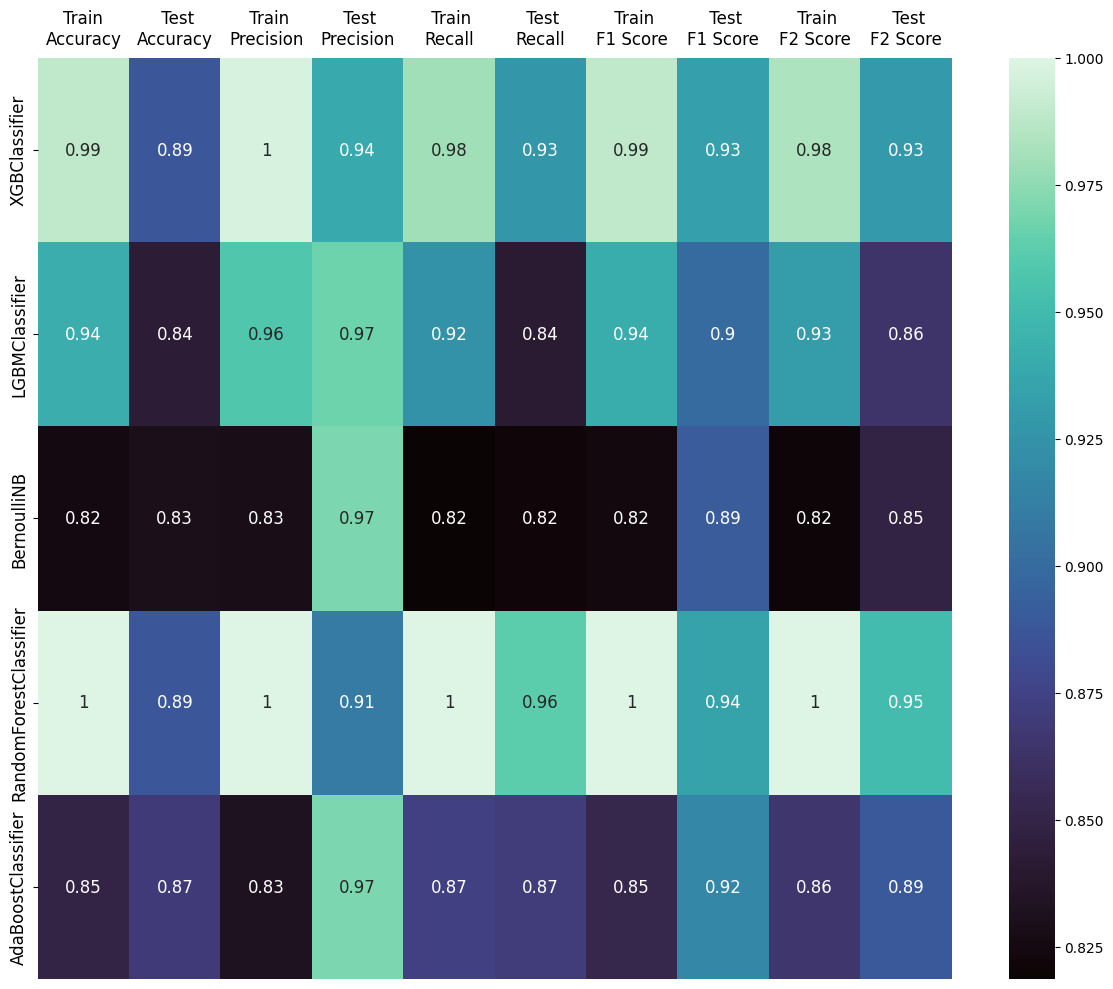

In [14]:
# Define Classification Algorithm
models = [XGBClassifier(random_state = 400),
          LGBMClassifier(random_state = 400),
          BernoulliNB(),
          RandomForestClassifier(random_state = 400),
          AdaBoostClassifier(random_state = 400)]

# Create model
create_model(X_train, X_test, y_train, y_test, models)

Berdasarkan eksperimen yang telah dilakukan, kami memiliki berbagai skor metrik yang berbeda-beda. Kami memutuskan untuk melakukan _Hyperparameter Tuning_ terhadap dua Algoritma dengan skor F1 dan F2 tertinggi, yaitu `RandomForestClassifier` dan `XGBClassifier`.

Namun, skor yang tinggi juga mengindikasikan adanya kecenderungan _overfit_, sehingga perlu dilakukan validasi dengan _cross-validation_ lebih lanjut.

## Hyperparameter Tuning for Machine Learning Models

In [15]:
X = X_train

In [16]:
# Define function
def model_evaluation(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)
    
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
    print("F2-Score (Test Set): %.2f" % fbeta_score(y_test, y_pred, beta = 2))
    print("ROC-AUC Score (Test-Probability): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("ROC-AUC Score (Train-Probability): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))

def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('Score')
    plt.ylabel('Feature')
    plt.title('Feature Importance Score')

def show_best_parameter(model):
    print(model.best_estimator_.get_params())

# 1. Random Forest Classifier

## Fit Model

In [17]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state = 400, class_weight = 'balanced')
rf.fit(X_train, y_train)
model_evaluation(rf)

Accuracy (Test Set): 0.89
Precision (Test Set): 0.71
Recall (Test Set): 0.50
F1-Score (Test Set): 0.59
F2-Score (Test Set): 0.53
ROC-AUC Score (Test-Probability): 0.90
ROC-AUC Score (Train-Probability): 1.00


## Hyperparameter Tuning

Link: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [18]:
# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV

# Dict
parameters = {'n_estimators': [int(x) for x in np.linspace(1, 200, num = 40)],     # number of trees in the forest
              'criterion': ['gini', 'entropy'],                                    # function to measure the quality of a split
              'max_depth': [int(x) for x in np.linspace(2, 100, num = 40)],        # max depth of the tree
              'min_samples_split': [int(x) for x in np.linspace(2, 20, num = 10)], # min number of samples required to split an internal node
              'min_samples_leaf': [int(x) for x in np.linspace(2, 20, num = 10)],  # min number of samples required to be at a leaf node
              'max_features' : ['sqrt', 'log2', None]                              # number of features to consider when looking for the best split
              }

# Init
rf = RandomForestClassifier(random_state=400, class_weight = 'balanced')
rf_rs = RandomizedSearchCV(rf, parameters, scoring='roc_auc', random_state=1, cv=5)
rf_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=400),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 4, 7, 9, 12, 14, 17,
                                                      19, 22, 24, 27, 29, 32,
                                                      34, 37, 39, 42, 44, 47,
                                                      49, 52, 54, 57, 59, 62,
                                                      64, 67, 69, 72, 74, ...],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [2, 4, 6, 8, 10, 12,
                                                             14, 16, 18, 20],
                                        'min_samples_split': [2, 4, 6, 8, 10,
                                                              12, 14, 16, 18,
                                                              20],
                                        'n_estimators': [1, 6, 11, 16, 21, 26,
                                                         31, 36, 41, 46, 52, 57,
                                                         62, 67, 72, 77, 82, 87,
                                                         92, 97, 103, 108, 113,
                                                         118, 123, 128, 133,
                                                         138, 143, 148, ...]},
                   random_state=1, scoring='roc_auc')

In [19]:
# Predict & Evaluation
model_evaluation(rf_rs)

Accuracy (Test Set): 0.90
Precision (Test Set): 0.73
Recall (Test Set): 0.58
F1-Score (Test Set): 0.64
F2-Score (Test Set): 0.60
ROC-AUC Score (Test-Probability): 0.90
ROC-AUC Score (Train-Probability): 1.00


In [20]:
# Best parameter
show_best_parameter(rf_rs)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 27, 'max_features': None, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 189, 'n_jobs': None, 'oob_score': False, 'random_state': 400, 'verbose': 0, 'warm_start': False}


In [21]:
# Prediction on training set
y_pred_train = rf_rs.predict(X_train)
# Prediction on testing set
y_pred = rf_rs.predict(X_test)

# Evaluate model
train_test_result(y_train, y_pred_train, y_test, y_pred)

TRAINING RESULTS:
-------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      8350
           1       0.99      1.00      1.00      8350

    accuracy                           1.00     16700
   macro avg       1.00      1.00      1.00     16700
weighted avg       1.00      1.00      1.00     16700

-------------------------------------------------------
Confusion Matrix:
[[8298   52]
 [   2 8348]]
-------------------------------------------------------

TESTING RESULTS:
-------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2072
           1       0.73      0.58      0.64       394

    accuracy                           0.90      2466
   macro avg       0.82      0.77      0.79      2466
weighted avg       0.89      0.90      0.89      2

<Axes: >

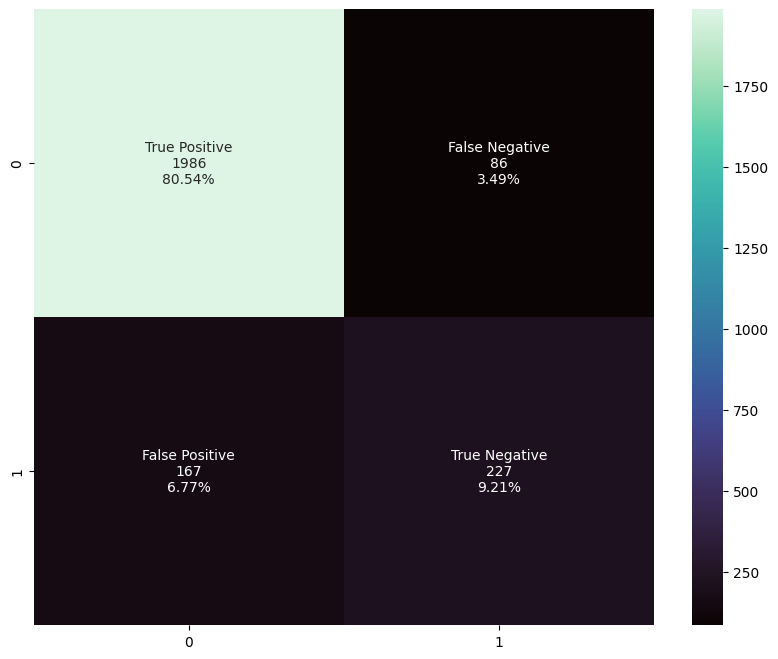

In [22]:
y_pred = rf_rs.predict(X_test)
c_matrix = confusion_matrix(y_test, y_pred)

names = ['True Positive', 'False Negative', 'False Positive', 'True Negative']
counts = ['{0:0.0f}'.format(value) for value in c_matrix.flatten()]
percentages = ['{0:.2%}'.format(value) for value in c_matrix.flatten() / np.sum(c_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, percentages)]
labels = np.asarray(labels).reshape(2, 2)

plt.figure(figsize = (10, 8))
sns.heatmap(c_matrix, annot = labels, fmt = '', cmap = 'mako')

## Learning Curve

parameter value: 2; train: 0.8660606188819965; test: 0.8866675322893598
parameter value: 4; train: 0.9015582487719171; test: 0.898385287027419
parameter value: 6; train: 0.9330069704901575; test: 0.9046869794014465
parameter value: 8; train: 0.9577096274516834; test: 0.8940655439703663
parameter value: 10; train: 0.9759501810749759; test: 0.8755120239891814
parameter value: 12; train: 0.9915189859801354; test: 0.8817291956568607
parameter value: 14; train: 0.9975418552117322; test: 0.8582704123630519
parameter value: 16; train: 0.9997923769228011; test: 0.8709822041040315
parameter value: 18; train: 0.9999743769945139; test: 0.8615556954706701
parameter value: 20; train: 0.9999928000286851; test: 0.8107765125531623
parameter value: 22; train: 0.9999979776972999; test: 0.8701063735962213
parameter value: 24; train: 0.9999971028003872; test: 0.8515075309174294
parameter value: 26; train: 0.999999411954534; test: 0.8401486829469063
parameter value: 28; train: 0.9999993258991; test: 0.8593

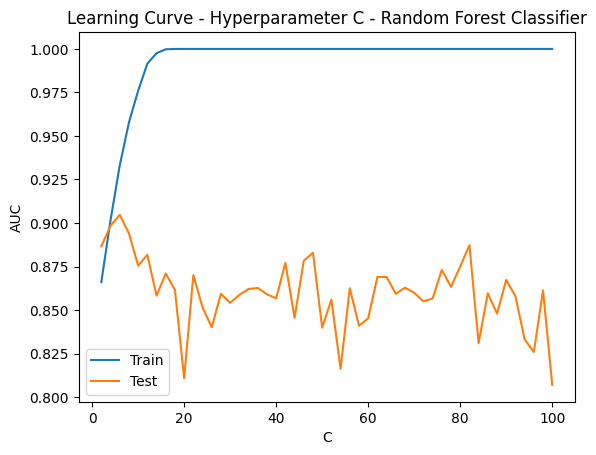

In [23]:
# Learning Curve
# param_values = [int(x) for x in np.linspace(1, 200, 50)] # n_estimators
param_values = [int(x) for x in np.linspace(2, 100, 50)] # max_depth
# param_values = [int(x) for x in np.linspace(2, 20, 15)]  # min_samples_split
# param_values = [int(x) for x in np.linspace(2, 20, 15)]  # min_samples_leaf

train_scores = []
test_scores = []

for c in param_values:
    model = RandomForestClassifier(n_estimators=10, max_depth=c)
    model.fit(X_train, y_train)

    # Evaluation on training set
    y_pred_train_proba = model.predict_proba(X_train)
    train_auc = roc_auc_score(y_train, y_pred_train_proba[:,1])
    train_scores.append(train_auc)

    # Evaluation on testing set
    y_pred_proba = model.predict_proba(X_test)
    test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
    test_scores.append(test_auc)

    print('parameter value: ' + str(c) + '; train: ' + str(train_auc) + '; test: '+ str(test_auc))

plt.plot(param_values, train_scores, label='Train')
plt.plot(param_values, test_scores, label='Test')
plt.xlabel('C')
plt.ylabel('AUC')
plt.title('Learning Curve - Hyperparameter C - Random Forest Classifier')
plt.legend()
plt.show()

## Feature Importance

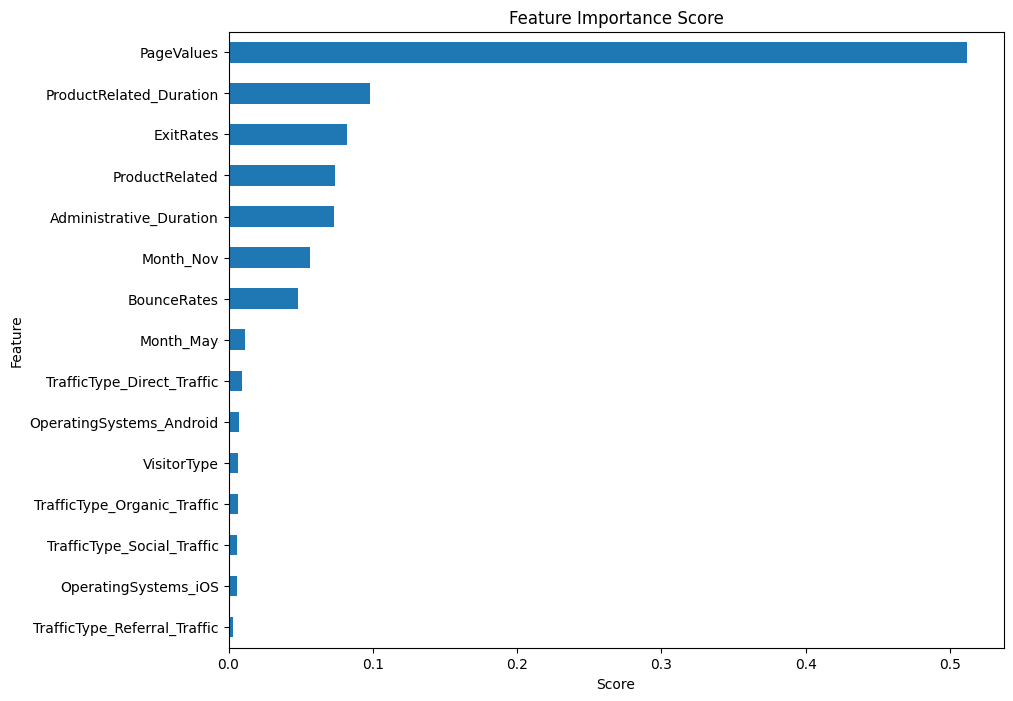

In [24]:
show_feature_importance(rf_rs.best_estimator_)

# 2. XGBoost Classifier

## Fit Model

Gunakan `scale_pos_weight`

In [25]:
from xgboost import XGBClassifier

xg = XGBClassifier()
xg.fit(X_train, y_train)
model_evaluation(xg)

Accuracy (Test Set): 0.89
Precision (Test Set): 0.64
Recall (Test Set): 0.68
F1-Score (Test Set): 0.66
F2-Score (Test Set): 0.67
ROC-AUC Score (Test-Probability): 0.91
ROC-AUC Score (Train-Probability): 1.00


## Hyperparameter Tuning

Link: https://xgboost.readthedocs.io/en/stable/parameter.html#parameters-for-tree-booster

In [26]:
# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV

# Dict
parameters = {'eta' : [float(x) for x in np.linspace(0, 1, num = 100)],             # learning_rate, step size shrinkage used in update to prevents overfitting
              'gamma' : [float(x) for x in np.linspace(0, 1, num = 11)],            # min_split_loss, min loss reduction required to make a further partition on a leaf node of the tree
              'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],       # max depth of a tree
              'min_child_weight' : [int(x) for x in np.linspace(1, 20, num = 11)],  # min sum of instance weight (hessian) needed in a child
              'subsample' : [float(x) for x in np.linspace(0, 1, num = 11)],        # subsample ratio of the training instances
              'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 11)], # subsample ratio of columns when constructing each tree
              'lambda' : [float(x) for x in np.linspace(0, 1, num = 11)],           # reg_lambda, L2 regularization term on weights
              'alpha' : [float(x) for x in np.linspace(0, 1, num = 11)],            # reg_alpha, L1 regularization term on weights
              'tree_method' : ['auto', 'exact', 'approx', 'hist']                   # tree construction algorithm used in XGBoost
              }

# Init
xg = XGBClassifier(random_state = 400)
xg_rs = RandomizedSearchCV(xg, parameters, scoring='roc_auc', random_state=1, cv=5)
xg_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                                   0.30000000000000004, 0.4,
                                                   0.5, 0.6000000000000001,
                                                   0.7000000000000001, 0.8, 0.9,
                                                   1.0],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'min_child_weight': [1, 2, 4, 6, 8, 10,
                                                             12, 14, 16, 18,
                                                             20],
                                        'subsample': [0.0, 0.1, 0.2,
                                                      0.30000000000000004, 0.4,
                                                      0.5, 0.6000000000000001,
                                                      0.7000000000000001, 0.8,
                                                      0.9, 1.0],
                                        'tree_method': ['auto', 'exact',
                                                        'approx', 'hist']},
                   random_state=1, scoring='roc_auc')

In [27]:
# Predict & Evaluation
model_evaluation(xg_rs)

Accuracy (Test Set): 0.88
Precision (Test Set): 0.60
Recall (Test Set): 0.71
F1-Score (Test Set): 0.65
F2-Score (Test Set): 0.68
ROC-AUC Score (Test-Probability): 0.91
ROC-AUC Score (Train-Probability): 1.00


In [28]:
# Best parameter
show_best_parameter(xg_rs)

{'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.6000000000000001, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 50, 'max_leaves': None, 'min_child_weight': 12, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': 400, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 1.0, 'tree_method': 'exact', 'validate_parameters': None, 'verbosity': None, 'lambda': 0.9, 'eta': 0.888888888888889, 'alpha': 0.1}


In [29]:
# Prediction on training set
y_pred_train = xg_rs.predict(X_train)
# Prediction on testing set
y_pred = xg_rs.predict(X_test)

# Evaluate model
train_test_result(y_train, y_pred_train, y_test, y_pred)

TRAINING RESULTS:
-------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8350
           1       1.00      1.00      1.00      8350

    accuracy                           1.00     16700
   macro avg       1.00      1.00      1.00     16700
weighted avg       1.00      1.00      1.00     16700

-------------------------------------------------------
Confusion Matrix:
[[8328   22]
 [   0 8350]]
-------------------------------------------------------

TESTING RESULTS:
-------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      2072
           1       0.60      0.71      0.65       394

    accuracy                           0.88      2466
   macro avg       0.77      0.81      0.79      2466
weighted avg       0.89      0.88      0.88      2

<Axes: >

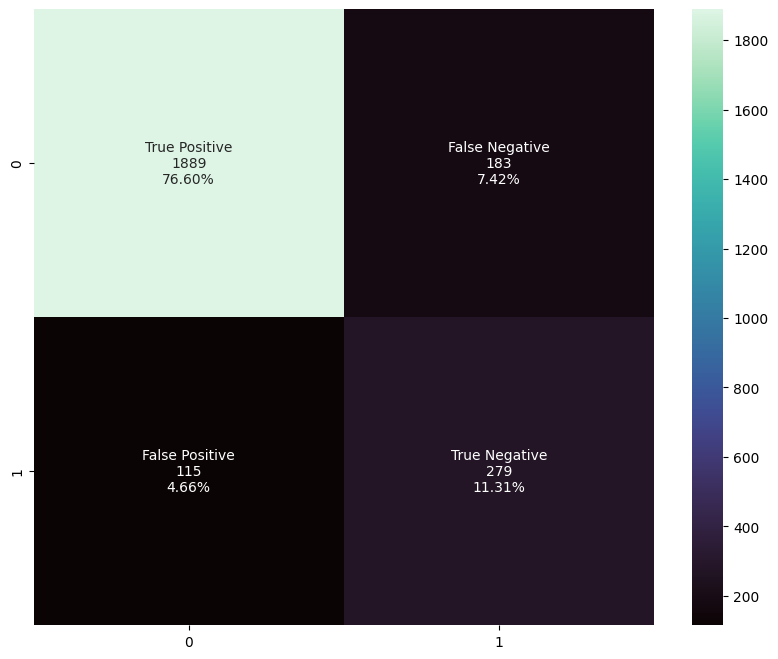

In [30]:
y_pred = xg_rs.predict(X_test)
c_matrix = confusion_matrix(y_test, y_pred)

names = ['True Positive', 'False Negative', 'False Positive', 'True Negative']
counts = ['{0:0.0f}'.format(value) for value in c_matrix.flatten()]
percentages = ['{0:.2%}'.format(value) for value in c_matrix.flatten() / np.sum(c_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, percentages)]
labels = np.asarray(labels).reshape(2, 2)

plt.figure(figsize = (10, 8))
sns.heatmap(c_matrix, annot = labels, fmt = '', cmap = 'mako')

## Learning Curve

parameter value: 2; train: 0.9230948546021729; test: 0.9308228641984987
parameter value: 4; train: 0.9396060525655276; test: 0.92851385649609
parameter value: 6; train: 0.9581834486715193; test: 0.9180933108598083
parameter value: 8; train: 0.9783013876438739; test: 0.8856440967798836
parameter value: 10; train: 0.9937053677076984; test: 0.8849115839915332
parameter value: 12; train: 0.9979944852809352; test: 0.8983644630852754
parameter value: 14; train: 0.9994602531464017; test: 0.8914472394802344
parameter value: 16; train: 0.9996982968195345; test: 0.8951165405797387
parameter value: 18; train: 0.9998038438093872; test: 0.9108674029359308
parameter value: 20; train: 0.9998382086127147; test: 0.914399511004841
parameter value: 22; train: 0.9998352827279572; test: 0.9103566038845228
parameter value: 24; train: 0.999840245257987; test: 0.9124634968543599
parameter value: 26; train: 0.9998375631969593; test: 0.9126117143249122
parameter value: 28; train: 0.9998419233389508; test: 0.912

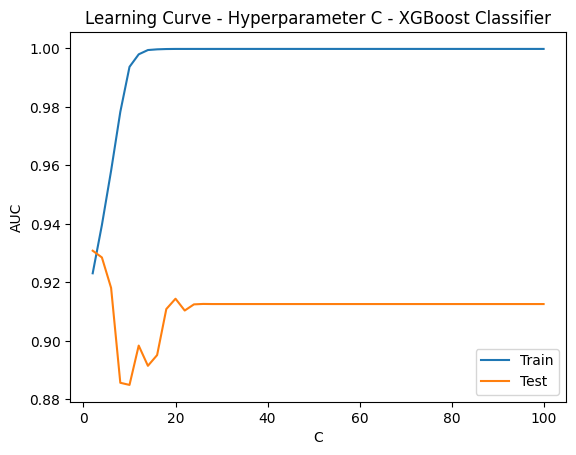

In [31]:
# Learning Curve
# param_values = [int(x) for x in np.linspace(1, 200, 50)] # n_estimators
param_values = [int(x) for x in np.linspace(2, 100, 50)] # max_depth
# param_values = [int(x) for x in np.linspace(2, 20, 15)]  # min_samples_split
# param_values = [int(x) for x in np.linspace(2, 20, 15)]  # min_samples_leaf

train_scores = []
test_scores = []

for c in param_values:
    model = XGBClassifier(n_estimators=10, max_depth=c)
    model.fit(X_train, y_train)

    # Evaluation on training set
    y_pred_train_proba = model.predict_proba(X_train)
    train_auc = roc_auc_score(y_train, y_pred_train_proba[:,1])
    train_scores.append(train_auc)

    # Evaluation on testing set
    y_pred_proba = model.predict_proba(X_test)
    test_auc = roc_auc_score(y_test, y_pred_proba[:,1])
    test_scores.append(test_auc)

    print('parameter value: ' + str(c) + '; train: ' + str(train_auc) + '; test: '+ str(test_auc))

plt.plot(param_values, train_scores, label='Train')
plt.plot(param_values, test_scores, label='Test')
plt.xlabel('C')
plt.ylabel('AUC')
plt.title('Learning Curve - Hyperparameter C - XGBoost Classifier')
plt.legend()
plt.show()

## Feature Importance

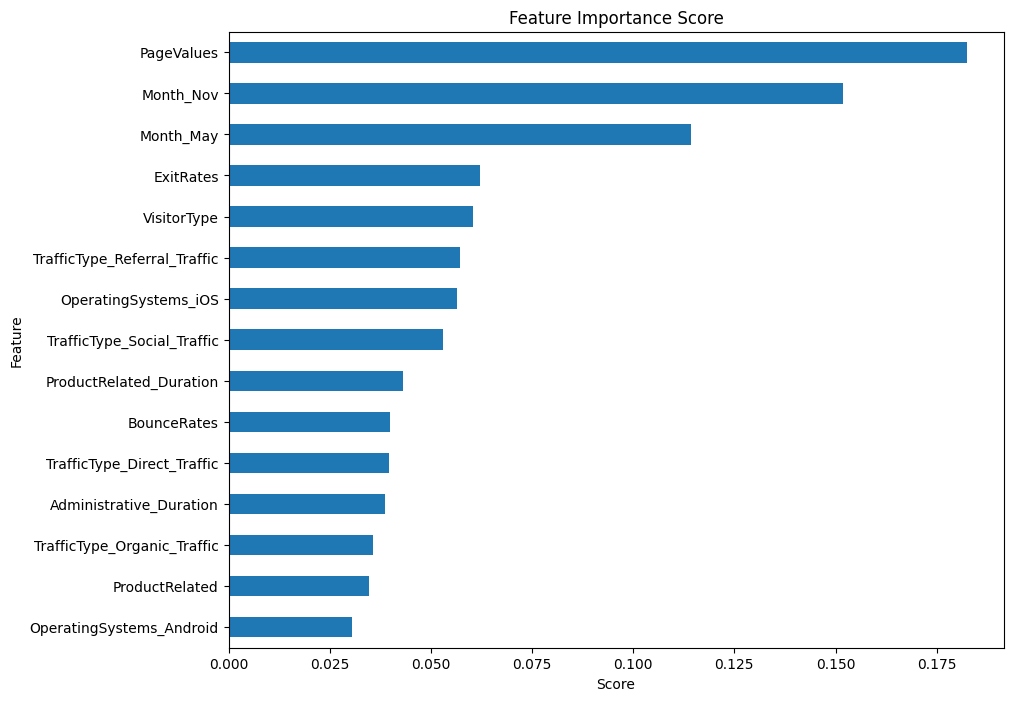

In [32]:
show_feature_importance(xg_rs.best_estimator_)

Berdasarkan _hyperparameter tuning_ di atas, ... memiliki _F1 Score_ tertinggi. Oleh karena itu, kami memutuskan untuk menginterpretasi model ini dan melakukan ekstraksi terhadap _feature importance_ dengan menggunakan metode SHAP.

# Explainable AI: Shap Value

# Feature Importance
- Apa yang menyebabkan hasil prediksi model demikian?

In [33]:
# pip install shap

Train the model

In [ ]:
rf_rs.fit(X_train, y_train)

Draw the plots

In [ ]:
# import shap
# explainer = shap.TreeExplainer(rf_rs)
# shap_values = explainer.shap_values(X_test)
# shap.summary_plot(shap_values[1], X_test) # Summary shap value terhadap label positive

Force Plot

In [ ]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_test.iloc[0,:])

## Feature Importance Evaluation

## Business Insights

## Business Recommendation

- Berikan action items berupa rekomendasi terhadap insight tersebut!

===

In [ ]:
# from sklearn.model_selection import cross_val_score

# # Define the model with best parameters
# rf = RandomForestClassifier(**best_params)

# # Perform cross-validation
# cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc')

# # Print the cross-validation scores
# print('Cross-validation scores:', cv_scores)
# print('Average cross-validation score:', np.mean(cv_scores))

- Apakah model sudah best-fit? Bagaimana mindari Overfit/Underfit?

- Hyperparameter yang digunakan dan pengaruhnya terhadap model?